[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kjmazidi/Machine_Learning_3rd_edition/blob/master/Volume_II_Python/Part-2-ML_sklearn/5-02-Regression_audi.ipynb)

# Regression
## Audi data

This notebook provides an example of regression with sklearn with a used car data set from [Kaggle](https://www.kaggle.com/datasets/mysarahmadbhat/audi-used-car-listings) 

The data set is available in the data folder, named  *audi.csv*


### Code Accompanying ***The Machine Learning Handbooks***, Volume II, Chapter 5

#### Book pdf is available on the GitHub repo: <https://github.com/kjmazidi/Machine_Learning_3rd_edition>

###### (c) 2025 KJG Mazidi, all rights reserved

In [34]:
# imports used in this notebook

import numpy as np
import pandas as pd
import seaborn as sb
import copy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import NearestNeighbors

### Data description

The preprocessed dataset contains a little over 44K rows and 12 columns. Experimentally we will determine which of these columns are useful for regression.

* model 
* year
* price (in Euros)
* transmission type
* mileage
* fuel type
* tax
* mpg
* engine size in liters

In [32]:
### load the data

df_in = pd.read_csv('data/audi.csv')  
print('Data dimentsion:', df_in.shape)
df_in.head()

Data dimentsion: (10668, 9)


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4
1,A6,2016,16500,Automatic,36203,Diesel,20,64.2,2.0
2,A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4
3,A4,2017,16800,Automatic,25952,Diesel,145,67.3,2.0
4,A3,2019,17300,Manual,1998,Petrol,145,49.6,1.0


The data has about 10K rows which is a good size. 

In [33]:
df_in.dtypes

model            object
year              int64
price             int64
transmission     object
mileage           int64
fuelType         object
tax               int64
mpg             float64
engineSize      float64
dtype: object

In [35]:
# make a copy of the data that won't alter the read-in data 

df = copy.deepcopy(df_in)

### Categorical data

Notice that model, transmission, and fuelType show up as "object." These are strings that needed to be converted to categorical representation. The *cat.codes* suffix is added to make the data numeric. 

In [36]:
# convert to categorical

df.transmission = df.transmission.astype('category').cat.codes
df.fuelType = df.fuelType.astype('category').cat.codes
df.model = df.model.astype('category').cat.codes
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,0,2017,12500,1,15735,2,150,55.4,1.4
1,5,2016,16500,0,36203,0,20,64.2,2.0
2,0,2016,11000,1,29946,2,30,55.4,1.4
3,3,2017,16800,0,25952,0,145,67.3,2.0
4,2,2019,17300,1,1998,2,145,49.6,1.0


### Data Exploration

Now let's try to figure out which columns might be good predictors of vehicle price. 

Looking at the numeric predictors:

* mileage has a moderated negative correlation, as does mpg
* year has a moderate positive correlation, as does model, tax, and engineSize
* fuelType has a very weak correlation with price


In [25]:
# correlation

df[['price', 'model', 'year', 'transmission', 'mileage', 'fuelType', 'tax', 'mpg', 'engineSize']].corr()

,price,model,year,transmission,mileage,fuelType,tax,mpg,engineSize
price,1.000000,0.394635,0.592581,0.009864,-0.535357,-0.032135,0.356157,-0.600334,0.591262
model,0.394635,1.000000,0.056775,-0.007999,-0.068694,-0.049588,0.393301,-0.408770,0.369126
year,0.592581,0.056775,1.000000,0.049203,-0.789667,0.122428,0.093066,-0.351281,-0.031582
transmission,0.009864,-0.007999,0.049203,1.000000,-0.042341,0.082359,-0.000919,-0.014149,-0.020070
mileage,-0.535357,-0.068694,-0.789667,-0.042341,1.000000,-0.240984,-0.166547,0.395103,0.070710
fuelType,-0.032135,-0.049588,0.122428,0.082359,-0.240984,1.000000,0.101257,-0.301099,-0.370507
tax,0.356157,0.393301,0.093066,-0.000919,-0.166547,0.101257,1.000000,-0.635909,0.393075
mpg,-0.600334,-0.408770,-0.351281,-0.014149,0.395103,-0.301099,-0.635909,1.000000,-0.365621
engineSize,0.591262,0.369126,-0.031582,-0.020070,0.070710,-0.370507,0.393075,-0.365621,1.000000


### Data visualization

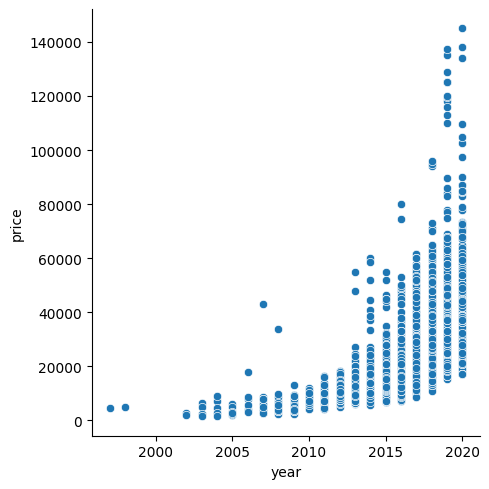

In [26]:
sb.relplot(x='year', y='price', data=df)

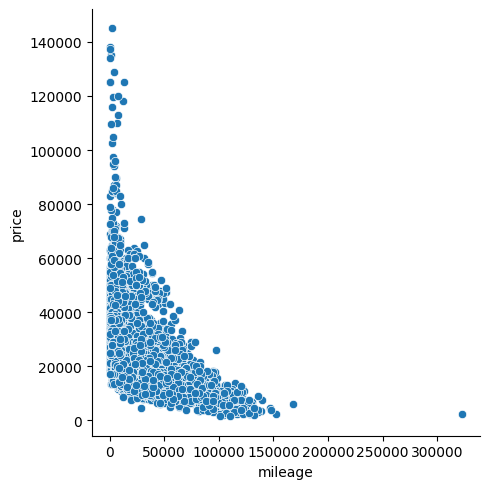

In [27]:
sb.relplot(x='mileage', y='price', data=df)

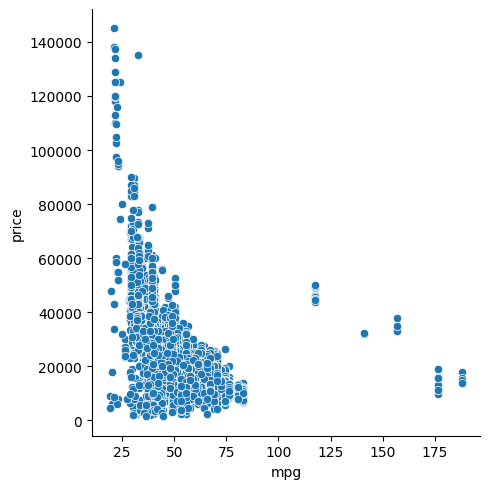

In [42]:
sb.relplot(x='mpg', y='price', data=df)

### Data inspection

Some of the charts raised some suspicious about how clean the data is. Let's dig further. 

The price range is from 1290 to 145K Euros. I like to physically look at the data in Excel so I can sort by column. Sorting on price, the cars over 100K are all 2020 vehicles. The lowest prices seem to be for early 2000 cars. I don't see any suspicious prices. 

In [29]:
print("price range is", min(df.price), "to", max(df.price))

price range is 1490 to 145000


In [43]:
print("mpg range is", min(df.mpg), "to", max(df.mpg))

mpg range is 18.9 to 188.3


Instead of looking at the Excel sheet, let's see how to explore this in pandas. 

We see that the phenomenal mpg cars are hybrids. Makes sense. 

In [46]:
df_in.sort_values(by='mpg', ascending = False).head(n=25)

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
4493,A3,2014,15490,Automatic,24597,Hybrid,0,188.3,1.4
3106,A3,2015,14981,Semi-Auto,28294,Hybrid,0,188.3,1.4
10392,A3,2015,14000,Automatic,63000,Hybrid,0,188.3,1.4
4879,A3,2014,15000,Semi-Auto,24597,Hybrid,0,188.3,1.4
4261,A3,2015,17990,Automatic,14000,Hybrid,0,188.3,1.4
10656,A3,2016,15495,Semi-Auto,52500,Hybrid,0,176.6,1.4
5717,A3,2016,18900,Semi-Auto,18486,Hybrid,0,176.6,1.4
10185,A3,2015,11240,Automatic,89000,Hybrid,0,176.6,1.4
8875,A3,2015,11295,Automatic,72260,Hybrid,0,176.6,1.4
8323,A3,2016,15499,Automatic,48573,Hybrid,0,176.6,1.4


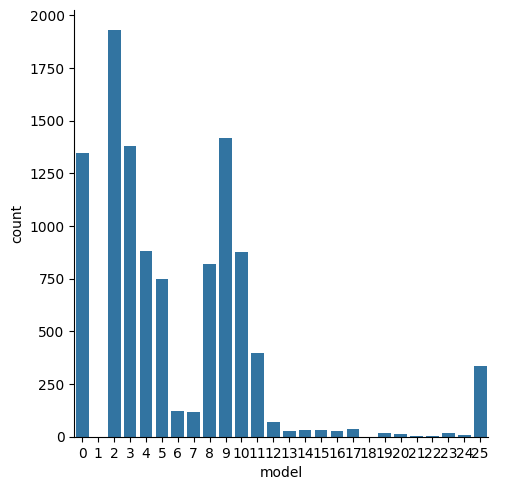

In [47]:
# price varies by model

sb.catplot(x="model", kind="count", data=df)

In [39]:
# how many models are there?

df_in.model.unique()

array([' A1', ' A6', ' A4', ' A3', ' Q3', ' Q5', ' A5', ' S4', ' Q2',
       ' A7', ' TT', ' Q7', ' RS6', ' RS3', ' A8', ' Q8', ' RS4', ' RS5',
       ' R8', ' SQ5', ' S8', ' SQ7', ' S3', ' S5', ' A2', ' RS7'],
      dtype=object)

Why are there three kinds of transmission? Let's look at the original data. Apparently, in addition to manual and automatic, cars can be semi-auto. 

In [37]:
df_in.transmission.unique()

array(['Manual', 'Automatic', 'Semi-Auto'], dtype=object)


## Simple Linear Regression

X is year, y is price

In [40]:
# make sure X is a data frame

X = df.year.to_frame()
y = df.price

In [41]:
# train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

print('train size:', X_train.shape)
print('test size:', X_test.shape)

train size: (8534, 1)
test size: (2134, 1)


In [11]:
# train the algorithm

linreg = LinearRegression()
linreg.fit(X_train, y_train)
linreg.score(X_train, y_train)

0.3443545701075845

In [12]:
# make predictions

y_pred = linreg.predict(X_test)

In [13]:
# evaluation

print('mse=', mean_squared_error(y_test, y_pred))
print('R2 Score: ', r2_score(y_test, y_pred))

mse= 77694587.0719462
R2 Score:  0.381116591974766


kjg

This is a very poor correlation result. Our data analysis showed a 0.25 correlation between yar and price. This correlation is essentially 0, meaning no correlation. The model was not able to learn well from the data. 

On a more positive note, the mean squared error indicates that the predicted car price would be off by about $5k which is not bad for one predictor. 

## Multiple Linear Regression

Let's add more predictors to the data this time. 

In [49]:
# predictors kjg numeric

X = df.iloc[:, [0,1,3,4,5,6,7,8]]
y = df.iloc[:, 2]

In [50]:
df.dtypes


model              int8
year              int64
price             int64
transmission       int8
mileage           int64
fuelType           int8
tax               int64
mpg             float64
engineSize      float64
dtype: object

In [51]:
X.head()

,model,year,transmission,mileage,fuelType,tax,mpg,engineSize
0,0,2017,1,15735,2,150,55.4,1.4
1,5,2016,0,36203,0,20,64.2,2.0
2,0,2016,1,29946,2,30,55.4,1.4
3,3,2017,0,25952,0,145,67.3,2.0
4,2,2019,1,1998,2,145,49.6,1.0


In [52]:
# train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

print('train size:', X_train.shape)
print('test size:', X_test.shape)

train size: (8534, 8)
test size: (2134, 8)


In [58]:
# train the algorithm

linreg = LinearRegression()
linreg.fit(X_train, y_train)
linreg.score(X_train, y_train)

0.7880686727341055

In [59]:
y_pred = linreg.predict(X_test)

In [60]:
# evaluation

print('mse=', mean_squared_error(y_test, y_pred))
print('correlation=', r2_score(y_test, y_pred))

mse= 27543000.87444141
correlation= 0.7806036830772836


<Axes: xlabel='price'>

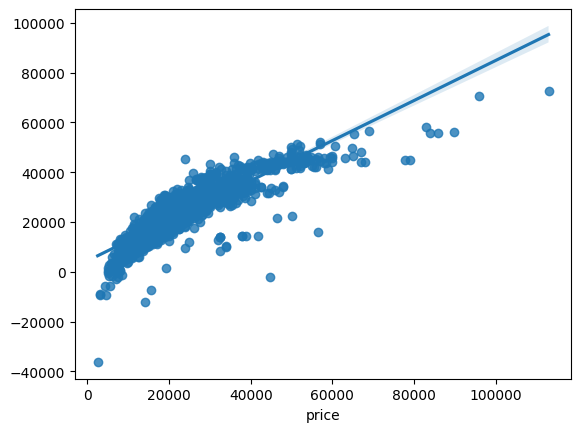

In [61]:
sb.regplot(x=y_test, y=y_pred)

In [48]:
# try knn


# train the algorithm
from sklearn.neighbors import KNeighborsRegressor
regressor = KNeighborsRegressor(n_neighbors=3)
regressor.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=3)

In [49]:
y_pred = regressor.predict(X_test)
print('mse=', mean_squared_error(y_test, y_pred))
print('correlation=', r2_score(y_test, y_pred))

mse= 106601343.30714361
correlation= 0.15085715579001147


<Axes: xlabel='price'>

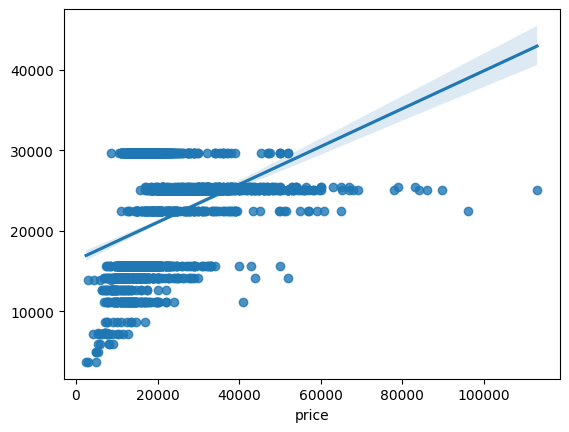

In [50]:
sb.regplot(x=y_test, y=y_pred)

In [51]:
# ridge regression
# 
reg = linear_model.Ridge(alpha=.5)

In [52]:
reg.fit(X_train, y_train)
reg.score(X_train, y_train)

0.3443545700558891

In [53]:
# Bayesian ridge

reg = linear_model.BayesianRidge()
reg.fit(X_train, y_train)
reg.score(X_train, y_train)

0.3443545529628598

In [54]:
reg = NearestNeighbors(n_neighbors=2)
reg.fit(X_train, y_train)


NearestNeighbors(n_neighbors=2)

In [55]:
y_pred = linreg.predict(X_test)

# evaluation

print('mse=', mean_squared_error(y_test, y_pred))
print('correlation=', r2_score(y_test, y_pred))


NameError: name 'linreg' is not defined

<Axes: xlabel='price'>

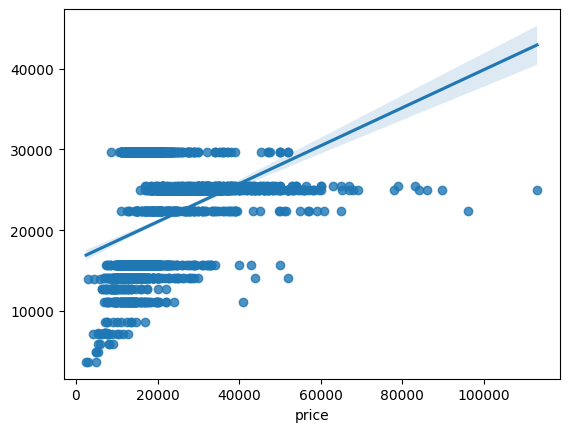

In [56]:
sb.regplot(x=y_test, y=y_pred)